# Imports and utility functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tpae.data.samples as tds
import tpae.data.patchcollection as tdp
import tpae.association as ta
import tpae.training as tt
import tpae.vis as tv
import gc, os
import scanpy as sc
import cna
import multianndata as md
import torch
torch.set_default_device('mps') # for running on Yakir's macbook's GPU, change to cuda for O2

patchsize = 40; patchstride = 10

In [29]:
def do_cna(d):
    cna.tl.nam(d, force_recompute=True)
    np.random.seed(0)
    res = cna.tl.association(d, d.samplem.case, donorids=d.samplem.donor.values, Nnull=100000)
    print(f'Ncases={d.samplem.case.sum()}: P = {res.p}, used {res.k} PCs')
    d.obs['ncorr'] = res.ncorrs
    if res.fdrs.fdr.min() <= 0.1:
        print(f'{res.fdrs[res.fdrs.fdr < 0.1].iloc[0].num_detected} at FDR 10%')
        d.obs['ncorr_thresh'] = res.ncorrs * (np.abs(res.ncorrs) > res.fdrs[res.fdrs.fdr < 0.1].iloc[0].threshold)
    else:
        d.obs['ncorr_thresh'] = 0
    d.samplem['yhat'] = res.yresid_hat

# Load dataset and make patches

In [5]:
# read in cells
cells = pd.read_csv('../../ALZ/alz-data/SEAAD_MTG_MERFISH_metadata.2024-05-03.noblanks.harmonized.txt', sep='\t')
cells['sid'] = cells.Section.str.split('_').str[1]
coarsecelltypes = cells.class_name.unique()
celltypes = cells.subclass_name.unique()
subcelltypes = cells.supertype_name.unique()

# read in samples
repname = 'pca_k=10_harmony'
samples = tds.read_samples(f'../../ALZ/alz-data/10u/{repname}/*.nc', tds.default_parser)

100%|███████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.37it/s]


In [6]:
# choose which patches to train on
P = tdp.PatchCollection(
    tds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.8),
                        samples, standardize=True)
sid_nums = {sid:sid_num for sid, sid_num in P.meta[['sid','sid_num']].drop_duplicates().values}
print(len(P), 'patches')

Pdense = tdp.PatchCollection(
    tds.choose_patches(samples, patchsize, patchstride, max_frac_empty=0.5),
                        samples, sid_nums=sid_nums, standardize=True)
print(len(Pdense), 'dense patches')

100%|███████████████████████████████████████████████████████████████| 75/75 [00:19<00:00,  3.86it/s]


in pytorch mode
means: [ 0.02981547  0.0177653   0.00884646  0.01154872  0.06730291 -0.03295387
 -0.00306103 -0.04015862  0.01382389 -0.00922448]
stds: [1.4054676  1.2029514  1.0251076  0.9518977  0.8700107  0.8795679
 0.92330146 0.797227   0.7747455  0.75200146]
data augmentation is off
172202 patches


100%|███████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.44it/s]


in pytorch mode
means: [ 0.2628232   0.01568338 -0.02149804  0.09026229  0.08598205 -0.03278659
  0.03346263 -0.06006299  0.00080287 -0.00665343]
stds: [1.4918594  1.3241493  1.1576263  1.0941674  0.997619   1.0063341
 1.019374   0.92432815 0.88095826 0.8894625 ]
data augmentation is off
70898 dense patches


75it [00:08,  8.59it/s]
/Users/yakir/Dropbox/py/tpae/data/samples.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


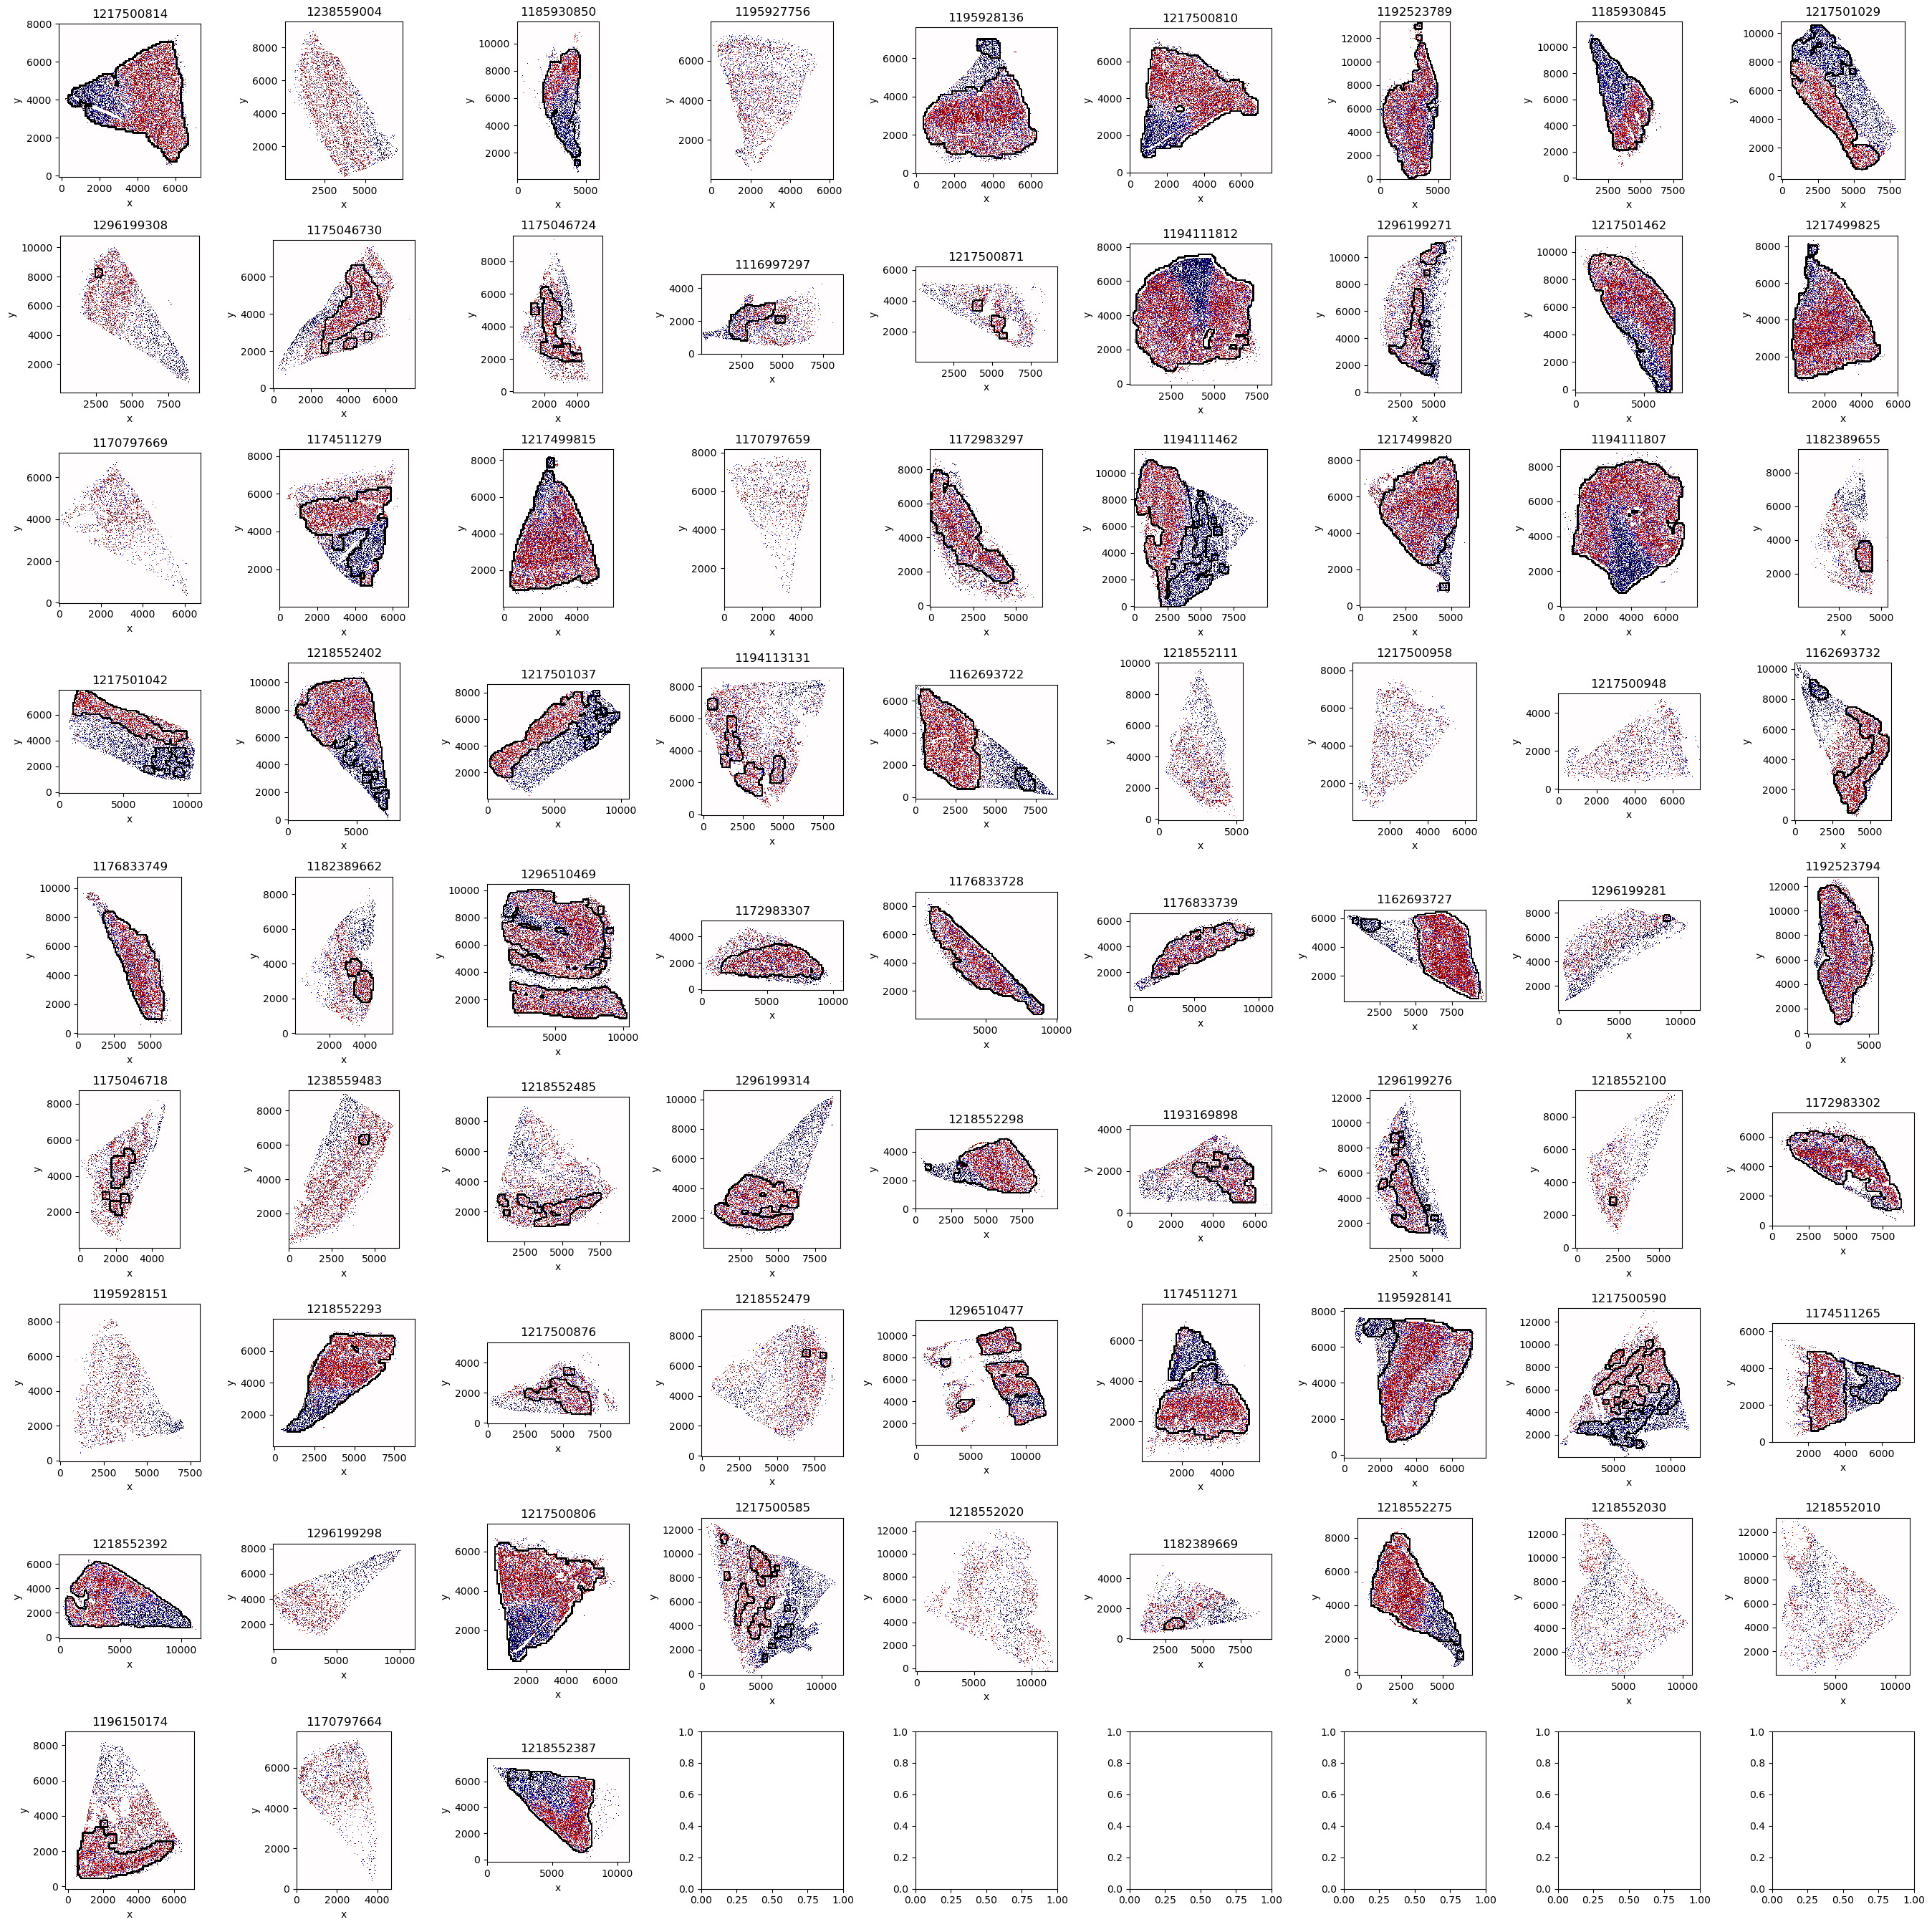

In [7]:
# visualize resulting patches
tds.plot_samples_with_patches(samples.values(), 'hPC1', Pdense.meta, ncols=9, vmin=-2, vmax=2, cmap='seismic'); plt.show()

In [8]:
# read in sample metadata
samplemeta = pd.read_csv('../../ALZ/alz-data/sea-ad_cohort_donor_metadata_encoded_20240924.tsv',
                         sep='\t').set_index('Donor ID', drop=True)

# Train VAE

In [10]:
from tpae.models.resnet_vae import ResnetVAE
tt.seed(0)
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=P.nchannels, nlatent=100)
kl_weight = 1e-5
name = 'default'
os.makedirs(f'_results/', exist_ok=True)

in pytorch mode
data augmentation is on


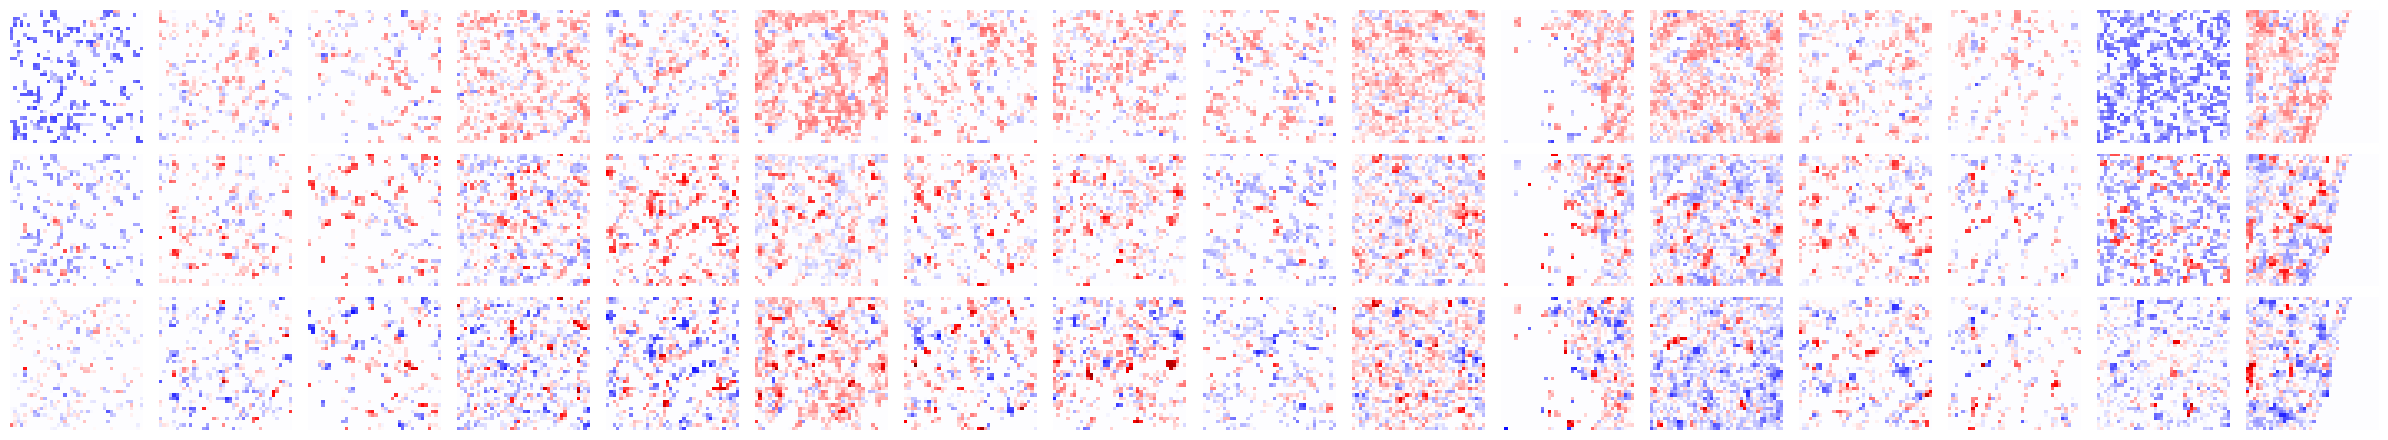

In [7]:
train_dataset, val_dataset = tt.train_test_split(P)
tv.plot_patches_separatechannels(val_dataset[:16][0].permute(0,2,3,1).cpu().numpy())

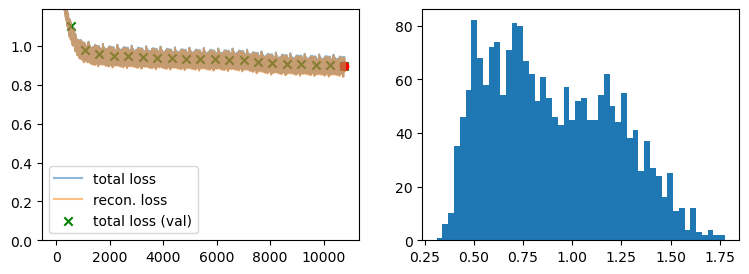

epoch 20. best validation loss = 0.9005340933799744
	total time: 234.7110300064087


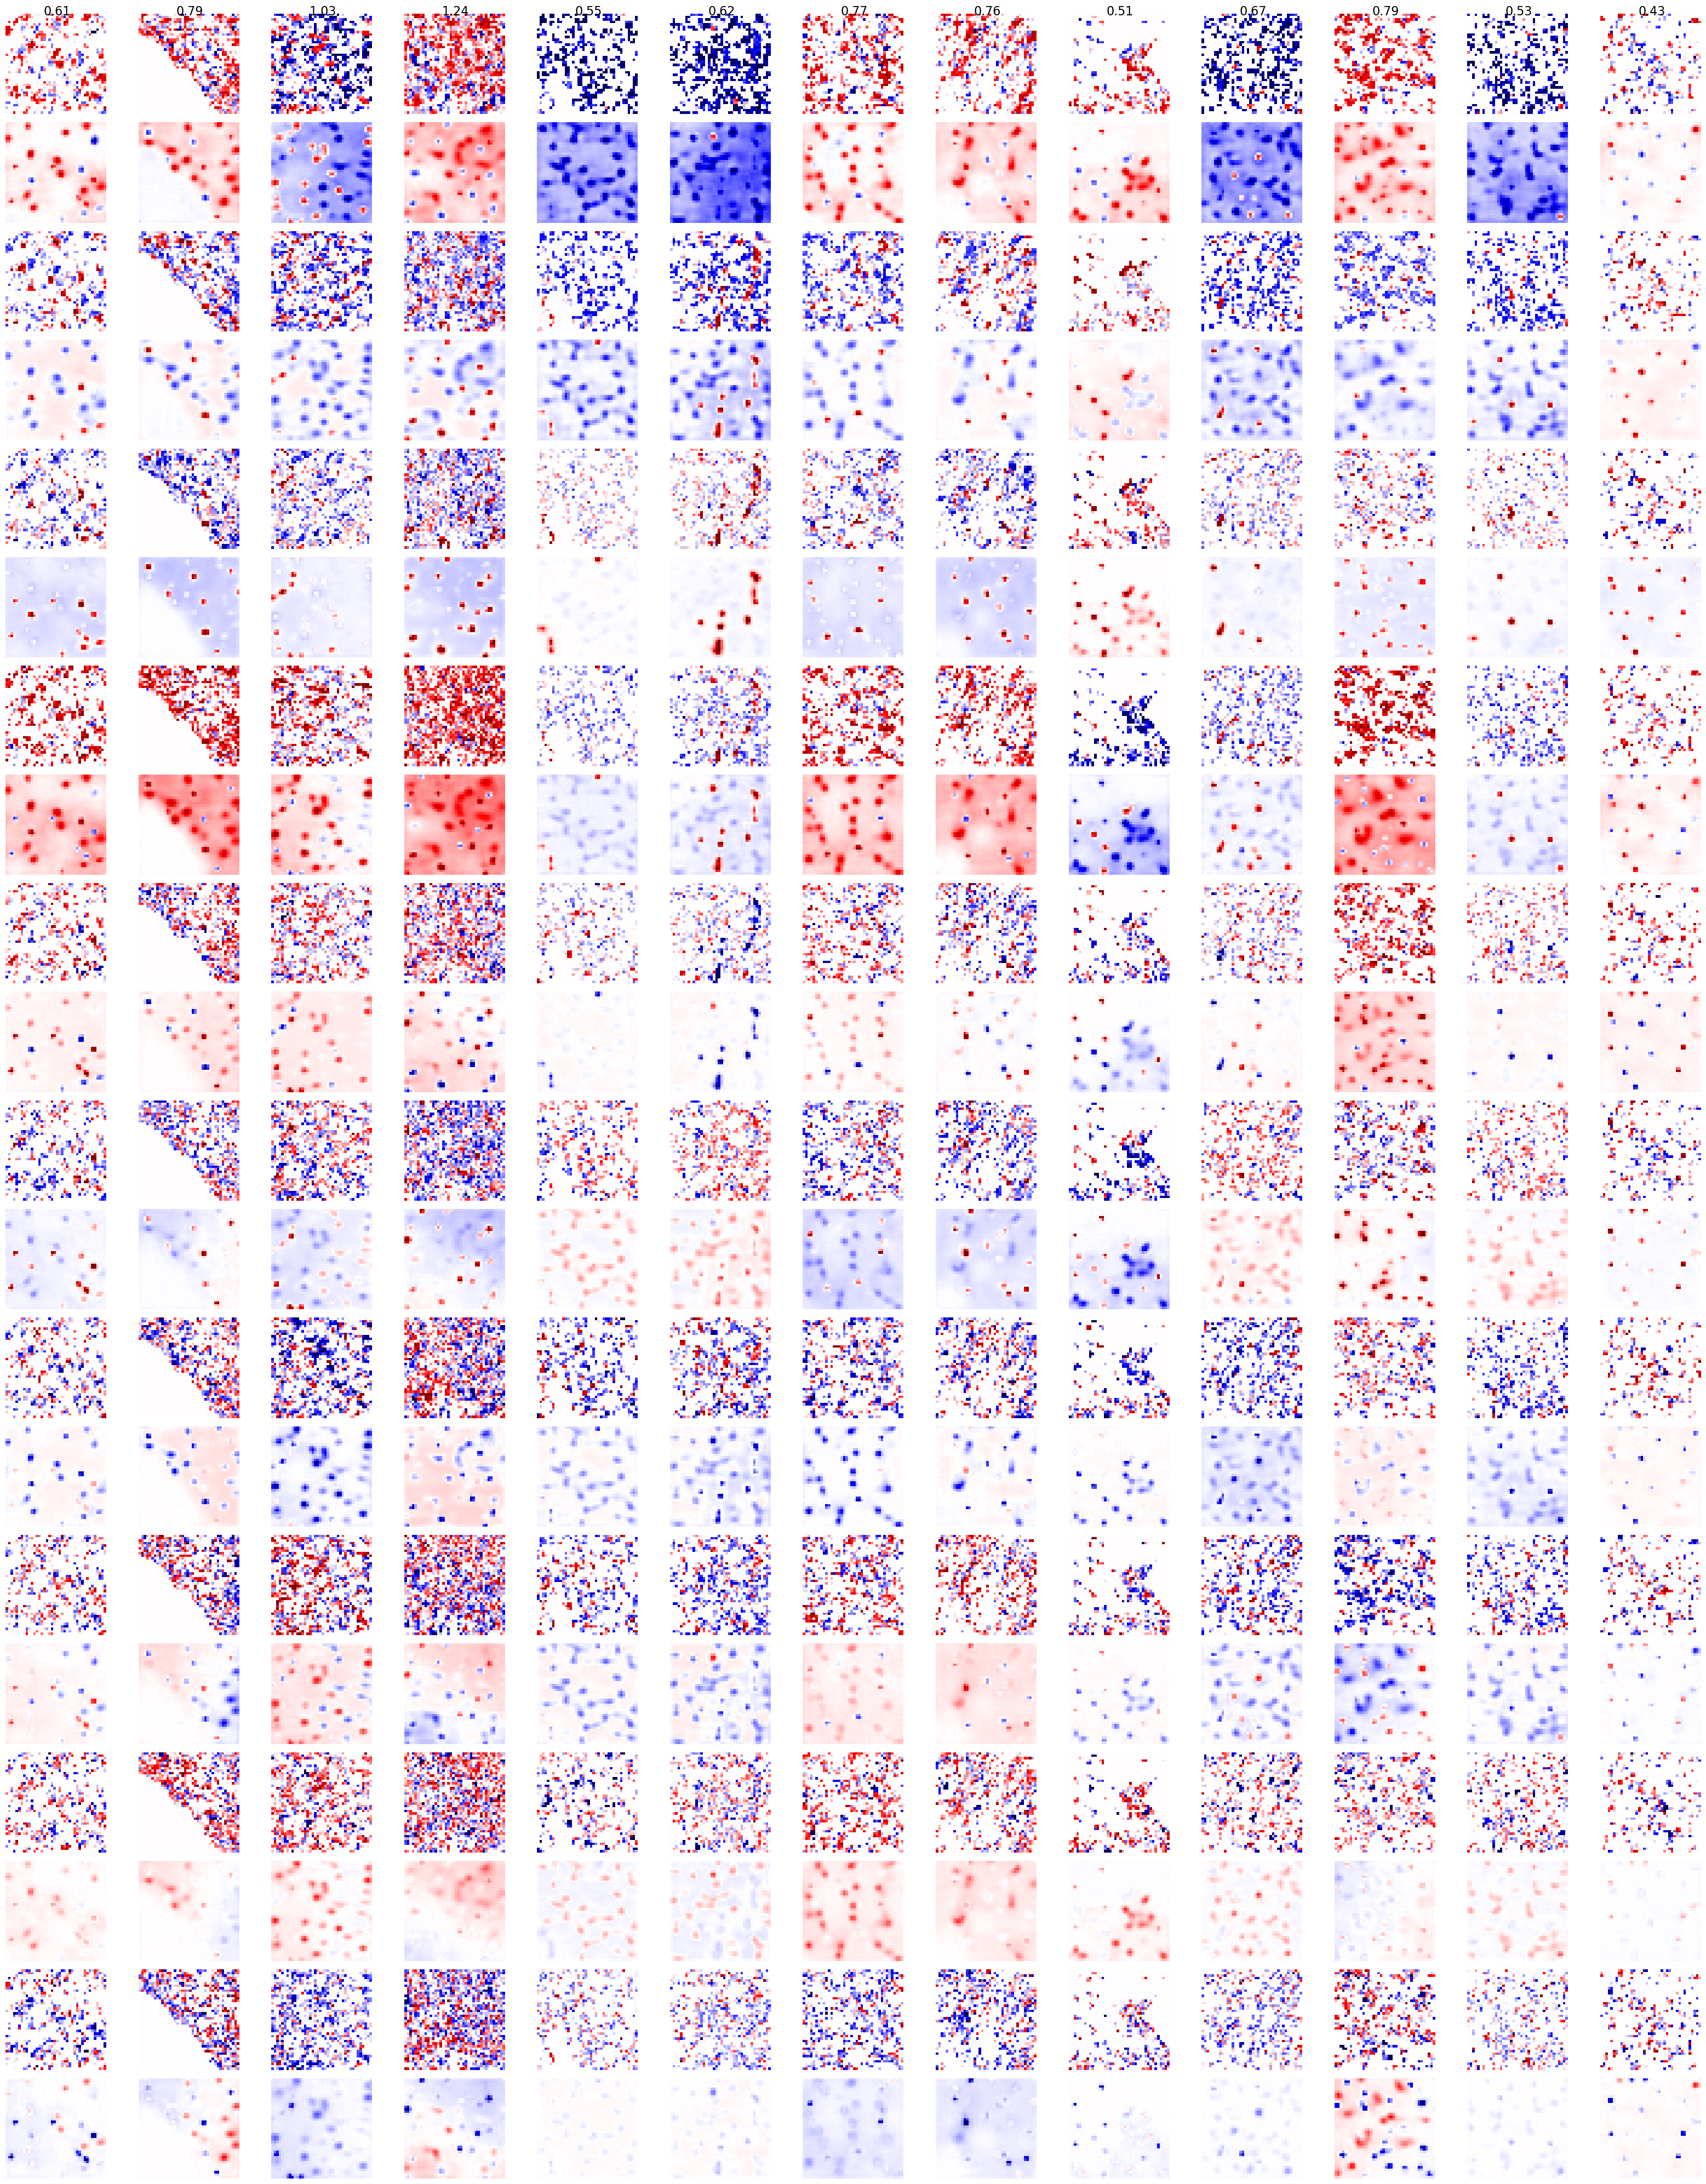

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
model, losslogs = tt.full_training(model, train_dataset, val_dataset, optimizer, scheduler, batch_size=256, n_epochs=20,
                                kl_weight=kl_weight,
                                per_epoch_logging=tt.detailed_per_epoch_logging,
                                per_epoch_kwargs={'Pmin':P.vmin, 'Pmax':P.vmax})
torch.save(model.state_dict(), f'_results/vae-{name}.pt')

# Create patch representations

In [52]:
def add_cellcounts(d, types):
    for sid in d.obs.sid.unique():
        print(sid, end='|')
        mycells = cells[cells.sid == sid]
        mypatches = d.obs[d.obs.sid == sid]
        cellcounts = pd.concat([
                mycells[(mycells.sid == sid)&(mycells.x >= x)&(mycells.x <= x+10*ps)&(mycells.y >= y)&(mycells.y <= y+10*ps)][types].value_counts()
                for sid,x,y,ps in mypatches[['sid','x_microns','y_microns', 'patchsize']].values
            ], axis=1).T.fillna(0)
        columns = cellcounts.columns.values
        d.obs.loc[d.obs.sid == sid, columns] = cellcounts.values

## VAE

In [53]:
# load model
from tpae.models.resnet_vae import ResnetVAE
model = ResnetVAE(len(P.meta.sid.unique()), network='light', mode='advanced', ncolors=P.nchannels, nlatent=100)
model.load_state_dict(torch.load(f'_results/{name}-vae.pt'))

# apply model and build umap
Ddense = ta.anndata(Pdense.meta,
                    ta.apply(model, Pdense, embedding=model.embedding),
                    pd.merge(samplemeta.loc[Pdense.meta.donor.unique()], Pdense.meta[['sid','donor']].drop_duplicates(),
                        left_index=True, right_on='donor', how='right').set_index('sid'),
                    sampleid='sid')
sc.pl.umap(Ddense, color='sid')
Ddense.samplem['case'] = Ddense.samplem['Consensus Clinical Dx (choice=Control)'] != 'Checked'
Ddense.samplem = Ddense.samplem[['donor','case']]

# add cell count information
add_cellcounts(Ddense, types='class_name')
add_cellcounts(Ddense, types='subclass_name')
add_cellcounts(Ddense, types='supertype_name')
Ddense.obs['totalcells'] = Ddense.obs[celltypes].sum(axis=1).values

Ddense.write(f'_results/{name}-vae.h5ad')

1217500814|1185930850|1195928136|1217500810|1192523789|1185930845|1217501029|1296199308|1175046730|1175046724|1116997297|1217500871|1194111812|1296199271|1217501462|1217499825|1174511279|1217499815|1172983297|1194111462|1217499820|1194111807|1182389655|1217501042|1218552402|1217501037|1194113131|1162693722|1162693732|1176833749|1182389662|1296510469|1172983307|1176833728|1176833739|1162693727|1296199281|1192523794|1175046718|1238559483|1218552485|1296199314|1218552298|1193169898|1296199276|1218552100|1172983302|1218552293|1217500876|1218552479|1296510477|1174511271|1195928141|1217500590|1174511265|1218552392|1217500806|1217500585|1182389669|1218552275|1196150174|1218552387|1217500814|1185930850|1195928136|1217500810|1192523789|1185930845|1217501029|1296199308|1175046730|1175046724|1116997297|1217500871|1194111812|1296199271|1217501462|1217499825|1174511279|1217499815|1172983297|1194111462|1217499820|1194111807|1182389655|1217501042|1218552402|1217501037|1194113131|1162693722|1162693732

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_98089/594426537.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Ddense.obs['totalcells'] = Ddense.obs[celltypes].sum(axis=1).values


## Cell counts

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_98089/2074774869.py:2: RuntimeWarning: invalid value encountered in divide
  X=np.nan_to_num(Ddense.obs[celltypes].values / Ddense.obs.totalcells.values[:,None]),


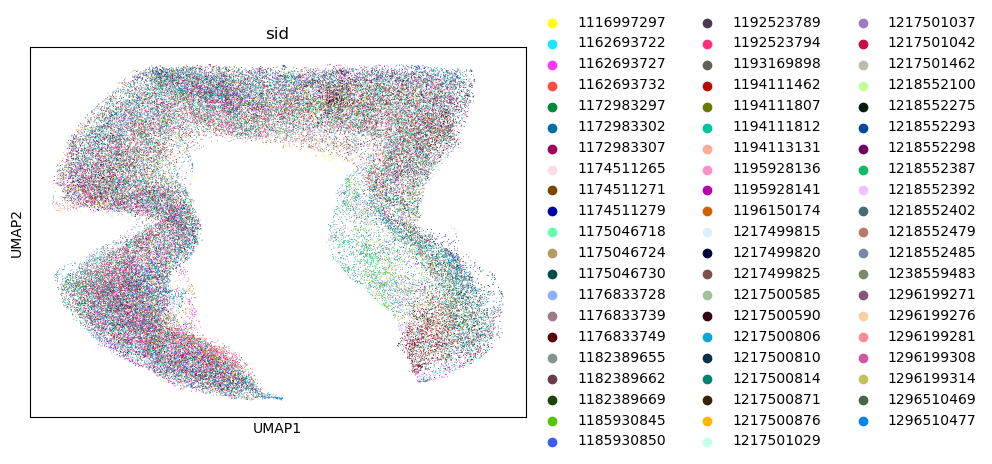

In [55]:
Ddense_cellabundance = md.MultiAnnData(
    X=np.nan_to_num(Ddense.obs[celltypes].values / Ddense.obs.totalcells.values[:,None]),
    obs=Ddense.obs)
Ddense_cellabundance.samplem = Ddense.samplem
Ddense_cellabundance.sampleid = 'sid'
sc.pp.neighbors(Ddense_cellabundance, use_rep='X')
sc.tl.umap(Ddense_cellabundance)
Ddense_cellabundance.write(f'_results/patchwidecellabundance.h5ad')
sc.pl.umap(Ddense_cellabundance, color='sid')

In [66]:
import anndata as ad
D_cellabundances = ad.AnnData(
    obs=P.meta)
add_cellcounts(D_cellabundances, types='class_name')
add_cellcounts(D_cellabundances, types='subclass_name')
add_cellcounts(D_cellabundances, types='supertype_name')
D_cellabundances.obs['totalcells'] = D_cellabundances.obs[celltypes].sum(axis=1).values

Ddense.write(f'_results/patchwidecellabundance_preQC.h5ad')

/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


1217500814|1238559004|1185930850|1195927756|1195928136|1217500810|1192523789|1185930845|1217501029|1296199308|1175046730|1175046724|1116997297|1217500871|1194111812|1296199271|1217501462|1217499825|1170797669|1174511279|1217499815|1170797659|1172983297|1194111462|1217499820|1194111807|1182389655|1217501042|1218552402|1217501037|1194113131|1162693722|1218552111|1217500958|1217500948|1162693732|1176833749|1182389662|1296510469|1172983307|1176833728|1176833739|1162693727|1296199281|1192523794|1175046718|1238559483|1218552485|1296199314|1218552298|1193169898|1296199276|1218552100|1172983302|1195928151|1218552293|1217500876|1218552479|1296510477|1174511271|1195928141|1217500590|1174511265|1218552392|1296199298|1217500806|1217500585|1218552020|1182389669|1218552275|1218552030|1218552010|1196150174|1170797664|1218552387|1217500814|1238559004|1185930850|1195927756|1195928136|1217500810|1192523789|1185930845|1217501029|1296199308|1175046730|1175046724|1116997297|1217500871|1194111812|1296199271

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_98089/154985146.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  D_cellabundances.obs['totalcells'] = D_cellabundances.obs[celltypes].sum(axis=1).values


## Patchwide avgs

In [ ]:
Pdense.numpy_mode()
Ddense_avg = md.MultiAnnData(
    X=Pdense[:][0].mean(axis=(1,2)),
    obs=Ddense.obs)
Ddense_avg.samplem = Ddense.samplem
Ddense_avg.sampleid = 'sid'
sc.pp.neighbors(Ddense_avg, use_rep='X')
sc.tl.umap(Ddense_avg)
Ddense_avg.write(f'_results/patchwideavgs.h5ad')
sc.pl.umap(Ddense_avg, color='sid')

# Case-control analysis

## patchwide cell abundances -> microniche analysis

In [57]:
Ddense_cellabundance = cna.read('_results/patchwidecellabundance.h5ad'); Ddense_cellabundance.sampleid = 'sid'
do_cna(Ddense_cellabundance)
Ddense_cellabundance.write(f'_results/patchwidecellabundance.h5ad')

Ncases=37: P = 0.14212857871421286, used 2 PCs


## patchwide averages -> microniche analysis

In [30]:
Ddense_avg = cna.read('_results/patchwideavgs.h5ad'); Ddense_avg.sampleid = 'sid'
do_cna(Ddense_avg)
Ddense_avg.write(f'_results/patchwideavgs.h5ad')

Ncases=37: P = 0.7291027089729103, used 3 PCs


## CNA VAE

In [68]:
Ddense = cna.read(f'_results/{name}-vae.h5ad'); Ddense.sampleid = 'sid'
do_cna(Ddense)

Ncases=37: P = 0.0023499765002349977, used 2 PCs
8039.0 at FDR 10%


In [69]:
# count number of patches of each type per sample
Ddense.samplem['npatches'] = Ddense.obs.sid.value_counts()
Ddense.samplem[['nneg', 'npos']] = pd.crosstab(Ddense.obs.sid, Ddense.obs.ncorr_thresh.map(
                                    lambda x: 0 if x < 0 else (1 if x > 0 else np.nan)
                                ))
Ddense.samplem = Ddense.samplem.fillna(0)

Ddense.obs['layer6'] = np.nan_to_num(Ddense.obs.L6b / Ddense.obs.totalcells) >= 0.05
Ddense.obs['manyoligo'] = np.nan_to_num(Ddense.obs.Oligodendrocyte / Ddense.obs.totalcells) >= 0.1
Ddense.obs['layer6_manyoligo'] = Ddense.obs.layer6 * Ddense.obs.manyoligo
Ddense.samplem['frac_layer6_manyoligo'] = Ddense.obs.groupby('sid').manyoligo.aggregate('mean')
Ddense.obs['layer23'] = np.nan_to_num(Ddense.obs['L2/3 IT'] / Ddense.obs.totalcells > 0.1)
Ddense.samplem['frac_layer23'] = Ddense.obs.groupby('sid').layer23.aggregate('mean')

Ddense.write(f'_results/{name}-vae.h5ad')

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_98089/1994708067.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Ddense.samplem['frac_layer6_manyoligo'] = Ddense.obs.groupby('sid').manyoligo.aggregate('mean')
/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_98089/1994708067.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Ddense.samplem['frac_layer23'] = Ddense.obs.groupby('sid').layer23.aggregate('mean')
